## Econometric estimation of an IRL-based market portfolio model

Welcome to your final course project on RL in Finance. In this project you will: 

- Explore and estimate an IRL-based model of market returns that is based on IRL of a market-optimal portfolio 
- Investigate the role and impact of choices of different signals on model estimation and trading strategies
- Compare simple IRL-based and UL-based trading strategies

**Instructions for project structure and grading principles :**

- This is a project that will be graded based on a peer-to-peer review. The project consists of four parts. The maximum score for each part is 10, so that maximum score you can give your peers (and they can give you) is 40. The parts are as follows (more detailed instructions are in specific cells below):

- **Part 1**: Complete the model estimation for the DJI portfolio of 30 stocks, and simple signals such as simple moving averages constructed below (Max 10 point).

- **Part 2**: Propose other signals and investigate the dynamics for market caps obtained with alternative signals. Present your conclusions and observations. (Max 10 point).

- **Part 3**: Can you repeat your analysis for the S&P portfolio? You will have to build a data file, build signals, and repeat the model estimation process with your new dataset (Max 10 points).

- **Part 4** : Show me something else. This part is optional. Come up with your own idea of an interesting analysis. For example, you can build a strategy using an optimal market-implied policy estimated from this model, and compare it with PCA and absorption ratio strategies that we built in Course 2. (Max 10 points).

**Instructions for formatting your notebook and packages use can use **

- Use one or more cells of the notebook for each section of the project. Each section is marked by a header cell below. Insert your cells between them without changing the sequence. 

- Think of an optimal presentation of your results and conclusions. Think of how hard or easy it will be for your fellow students to follow your logic and presentation. When you are grading others, you can add or subtract point for the quality of presentation.

- You will be using Python 3 in this project. Using TensorFlow is encouraged but is not strictly necessary, you can use optimization algorithms available in scipy or scikit-learn packages. If you use any non-standard packages, you should state all neccessary additional imports (or instructions how to install any additional modules you use in a top cell of your notebook. If you create a new portfolio for parts 3 and 4 in the project, make your code for creating your dataset replicable as well, so that your grader can reproduce your code locally on his/her machine.   

- Try to write a clean code that can be followed by your peer reviewer. When you are the reviewer, you can add or subtract point for the quality of code. 


**After completing this project you will:**
- Get experience with building and estimation of your first IRL based model of market dynamics, and learn how this IRL approach extends the famous Black-Litterman model (see F. Black and R. Litterman, "Global Portfolio Optimization", Financial Analyst Journal, Sept-Oct. 1992, 28-43, and  D. Bertsimas, V. Gupta, and I.Ch. Paschalidis, "Inverse Optimization: A New Perspective on the Black-Litterman Model", Operations Research, Vol.60, No.6, pp. 1389-1403 (2012), I.Halperin and I. Feldshteyn "Market Self-Learning of Signals, Impact and Optimal Trading: Invisible Hand Inference with Free Energy", https://papers.ssrn.com/sol3/papers.cfm?abstract\_id=3174498.). 
- Know how to enhance a market-optimal portfolio policy by using your private signals. 
- Be able to implement trading strategies based on this method.

Let's get started!

## The IRL-based model of stock returns

In Week 4 lectures of our course we found that optimal investment policy in the problem of inverse portfolio optimization is a Gaussian policy

$$ \pi_{\theta}({\bf a}_t |{\bf y}_t ) =   \mathcal{N}\left({\bf a}_t | \bf{A}_0 + \bf{A}_1 {\bf y}_t, \Sigma_p \right) $$

Here $ {\bf y}_t $ is a vector of dollar position in the portfolio, and $ \bf{A}_0 $, $ \bf{A}_1 $ and $ \Sigma_p $ are parameters defining a Gaussian policy.   

We said in the lecture that such Gaussian policy is found for both cases of a single investor and a market portfolio. We also sketched a numerical scheme that can iteratively compute coefficients $ \bf{A}_0$, $ \bf{A}_1 $ and $ \Sigma_p $ using a combination of a RL algorithm called G-learning and a trajectory optimization algorithm.

In this project, you will explore implications and estimation of this IRL-based model for the most interesting case - the market portfolio. It turns out that for this case, the model can be estimated in an easier way using a conventional Maximum Likelihood approach. To this end, we will re-formulate the model for this particular case in three easy steps.


Recall that for a vector of $ N $ stocks, we introduced a size $ 2 N $-action vector 
$ {\bf a}_t = [{\bf u}_t^{(+)}, {\bf u}_t^{(-)}] $, so that an action $ {\bf u}_t $ was defined as a difference of two non-negative numbers 
$ {\bf u}_t = {\bf u}_t^{(+)} -  {\bf u}_t^{(-)} = [{\bf 1}, - {\bf 1}] {\bf a}_t \equiv {\bf 1}_{-1}^{T} {\bf a}_t $.

Therefore, the joint distribution of $ {\bf a}_t = [{\bf u}_t^{(+)}, {\bf u}_t^{(-)} ] $ is given by our Gaussian policy
$  \pi_{\theta}({\bf a}_t |{\bf y}_t ) $. This means that the distribution of 
$ {\bf u}_t = {\bf u}_t^{(+)} -  {\bf u}_t^{(-)} $ is also Gaussian. Let us write it therefore as follows:

$$
\pi_{\theta}({\bf u}_t |{\bf y}_t ) =   \mathcal{N}\left({\bf u}_t | \bf{U}_0 + \bf{U}_1 {\bf y}_t, \Sigma_u \right) 
$$

Here $ \bf{U}_0 = {\bf 1}_{-1}^{T}  \bf{A}_0 $ and $ \bf{U}_1 =  {\bf 1}_{-1}^{T}  \bf{A}_1 $.

This means that $ {\bf u}_t $ is a Gaussian random variable that we can write as follows:

$$
{\bf u}_t = \bf{U}_0 + \bf{U}_1 {\bf y}_t + \varepsilon_t^{(u)}  = \bf{U}_0 + \bf{U}_1^{(x)} {\bf x}_t + \bf{U}_1^{(z)} {\bf z}_t + \varepsilon_t^{(u)} 
$$

where $ \varepsilon_t^{(u)} \sim \mathcal{N}(0,\Sigma_u) $ is a Gaussian random noise.  

The most important feature of this expression that we need going forward is is linear dependence on the state $ {\bf x}_t $. 
This is the only result that we will use in order to construct a simple dynamic market model resulting from our IRL model. We use a deterministic limit of this equation, where in addition we set $ \bf{U}_0 = \bf{U}_1^{(z)} = 0 $, and replace $ \bf{U}_1^{(x)} \rightarrow \phi $ to simplify the notation. We thus obtain a simple deterministic policy

$$
\label{determ_u}
{\bf u}_t =  \phi  {\bf x}_t 
$$

Next, let us recall the state equation and return equation (where we reinstate a time step $ \Delta t $,
and $ \circ $ stands for an element-wise (Hadamard) product):

$$
X_{t+ \Delta t} = (1 + r_t \Delta t) \circ (  X_t +  u_t  \Delta t)  
$$
$$
r_t   = r_f + {\bf w} {\bf z}_t -  \mu  u_t + \frac{\sigma}{ \sqrt{ \Delta t}} \varepsilon_t 
$$
where $ r_f $ is a risk-free rate, $ \Delta t $ is a time step, $ {\bf z}_t $ is a vector of predictors with weights $ {\bf w} $, $ \mu $ is a market impact parameter with a linear impact specification, and $ \varepsilon_t \sim \mathcal{N} (\cdot| 0, 1) $ is a white noise residual.


Eliminating $ u_t $ from these expressions and simplifying, we obtain
$$ \Delta  X_t = \mu  \phi  ( 1 + \phi \Delta t) \circ  X_t \circ \left(  \frac{r_f (1 + \phi \Delta t)  + \phi}{ \mu \phi (1+ \phi \Delta t )}  -  X_t \right) \Delta t + 
( 1 + \phi \Delta t) X_t  \circ \left[ {\bf w} {\bf z}_t  \Delta t +  \sigma \sqrt{ \Delta t} \varepsilon_t \right]
$$
Finally, assuming that $ \phi \Delta t \ll 1 $ and taking the continuous-time limit $  \Delta t \rightarrow dt $, we obtain 

$$
d X_t = \kappa \circ X_t \circ \left( \frac{\theta}{\kappa} - X_t \right) dt +  X_t \circ \left[ {\bf w} {\bf z}_t \, dt + \sigma d W_t \right]
$$
where $\kappa   =   \mu  \phi $, $ \theta  =   r_f + \phi $, and $ W_t $ is a standard Brownian motion.

Please note that this equation describes dynamics with a quadratic mean reversion. It is quite different from models with linear mean reversion such as the Ornstein-Uhlenbeck (OU) process. 

Without signals $ {\bf z}_t $, this process is known in the literature as a Geometric Mean Reversion (GMR) process. It has been used (for a one-dimensional setting) by Dixit and Pyndick (" Investment Under Uncertainty", Princeton 1994), and investigated (also for 1D) by Ewald and Yang ("Geometric Mean Reversion: Formulas for the Equilibrium Density and Analytic Moment Matching", {\it University of 
St. Andrews Economics Preprints}, 2007). We have found that such dynamics (in a multi-variate setting) can also be obtained for market caps (or equivalently for stock prices, so long as the number of shares is held fixed) using Inverse Reinforcement Learning! 

(For more details, see I. Halperin and I. Feldshteyn, "Market Self-Learning of Signals, Impact and Optimal Trading: Invisible Hand Inference with Free Energy.
(or, How We Learned to Stop Worrying and Love Bounded Rationality)", https://papers.ssrn.com/sol3/papers.cfm?abstract\_id=3174498) 


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from datetime import datetime

In [2]:

import sklearn.decomposition
from tensorflow.contrib.layers import fully_connected
import sys

import matplotlib.pyplot as plt
%matplotlib inline

print("Package Versions:")
print("  scikit-learn: %s" % sklearn.__version__)
print("  tensorflow: %s" % tf.__version__)

sys.path.append("..")
import grading

try:
    import sklearn.model_selection
    import sklearn.linear_model
except:
    print("Looks like an older version of sklearn package")

try:
    import pandas as pd
    print("  pandas: %s"% pd.__version__)
except:
    print("Missing pandas package")

Package Versions:
  scikit-learn: 0.18.2
  tensorflow: 1.10.1
  pandas: 0.19.2


In [3]:
import os
# load dataset


In [4]:
# read the data to a Dataframe
df_cap = pd.read_csv('dja_cap.csv')

In [5]:
# add dates
dates = pd.bdate_range(start='2010-01-04', end=None, periods=df_cap.shape[0], freq='B')
df_cap['date'] = dates

df_cap.set_index('date',inplace=True)
df_cap.head()


,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS,...,NKE,PFE,PG,TRV,UNH,UTX,V,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,1.937537e+11,48660795480,4.082033e+10,36460724400,1.420313e+11,1.586155e+11,6.168697e+10,3.337392e+10,1.645038e+11,8.897731e+10,...,25598248500,1.527563e+11,178576382080,27214839130,36638396010,67155918570,41337043020,94536765440,206625627560,3.272107e+11
2010-01-05,1.940887e+11,48553770270,4.215727e+10,36896634000,1.413985e+11,1.597391e+11,6.153308e+10,3.486077e+10,1.653556e+11,9.055040e+10,...,25700093100,1.505775e+11,178634816760,26570118990,36580295160,66152751840,40863360090,94707204320,204568134680,3.284884e+11
2010-01-06,1.910015e+11,49338621810,4.343609e+10,37008725040,1.404781e+11,1.597591e+11,6.120609e+10,3.547838e+10,1.645038e+11,8.958393e+10,...,25543409100,1.500934e+11,177787513900,26193121620,36940520430,65805862410,40314638280,90673484160,204110914040,3.313275e+11
2010-01-07,1.906484e+11,49921314620,4.519446e+10,37158179760,1.411109e+11,1.591572e+11,6.122532e+10,3.550126e+10,1.730218e+11,9.133695e+10,...,26172872700,1.495285e+11,176823341680,26570118990,38358181170,66087124110,40689832680,90133761040,204225219200,3.302865e+11
2010-01-08,1.919159e+11,49885639550,4.475850e+10,37575407520,1.418587e+11,1.594381e+11,6.132150e+10,3.562706e+10,1.767484e+11,8.960963e+10,...,26121202640,1.507389e+11,176589602960,26531872880,37997955900,66218379570,40802391000,90190574000,203196472760,3.289615e+11


In [6]:
len(df_cap)

2080

## Let us build some signals 

Here we provide a "warm start" by computing two simple moving average signals that you can use as benchmark in your analysis.

### Generate moving averages

In [7]:
# Calculating the short-window (10 days) simple moving average

window_1 = 10

short_rolling = df_cap.rolling(window=window_1).mean()
# short_rolling.head(20)

In [8]:
# Calculating the long-window (30 days) simple moving average

window_2 = 30
long_rolling = df_cap.rolling(window=window_2).mean()
# long_rolling.tail()

### Plot three years of AAPL stock:

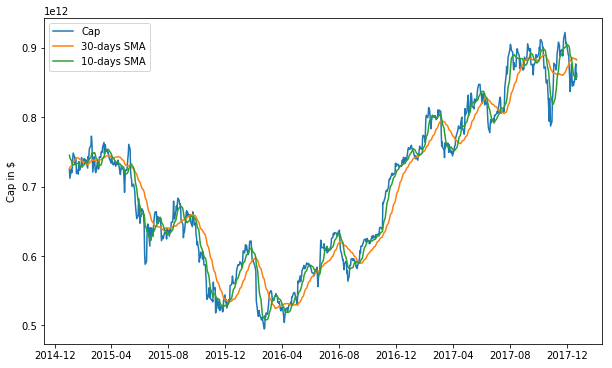

In [9]:
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2017-12-31'

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)

ax.plot(df_cap.loc[start_date:end_date, :].index, df_cap.loc[start_date:end_date, 'AAPL'], label='Cap')
ax.plot(long_rolling.loc[start_date:end_date, :].index, long_rolling.loc[start_date:end_date, 'AAPL'], 
          label = '%d-days SMA' % window_2)
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, 'AAPL'], 
         label = '%d-days SMA' % window_1)

ax.legend(loc='best')
ax.set_ylabel('Cap in $')

plt.show()

## Part 1: Model calibration with moving average signals (Max 10 points)

Recall the equation for the dynamics of market portfolio: 

$$ \Delta {\bf x}_t = \kappa_x \circ  {\bf x}_t \circ 
\left( {\bf W}{\bf z}_t'  - {\bf x}_t \right)  +  {\bf x}_t  \circ \varepsilon_t^{(x)} $$

Here we change the notation a bit. Now $ {\bf z}_t' $ is an extended vector of predictors that includes a constant unit predictor $  {\bf z}_t' = [1, {\bf z}_t ]^T $. Therefore, for each name, if you have $ K = 2 $ signals, an extended vector of signals $ {\bf z}_t' $ is of length $ K + 1 $, and the  $ W $ stands for a factor loading matrix.
The negative log-likelihood function for observable data with this model is therefore

$$  LL_M (\Theta) = - \log \prod_{t=0}^{T-1} 
\frac{1}{ \sqrt{ (2 \pi)^{N}  \left| \Sigma_x \right| }} 
e^{ - \frac{1}{2} \left(   {\bf v}_t
 \right)^{T} 
\Sigma_x^{-1}  
\left(  {\bf v}_t \right)} $$

where

$$  {\bf v}_t \equiv \frac{{\bf x}_{t+1} -  {\bf x}_{t}}{{\bf x}_{t}}  
-  \kappa_x \circ \left({\bf W} {\bf z}_t'   - {\bf x}_t \right)  $$

and $ \Sigma_x $ is the covariance matrix that was specified above in terms of other parameters. Here we directly infer the value of $ \Sigma_x $, along with other parameters, from data, so we will not use these previous expressions. 

Parameters that you have to estimate from data are therefore the vector of mean reversion speed 
parameters $ \kappa_x $, factor loading matrix $ {\bf W} \equiv {\bf w}_z' $, and covariance matrix $ \Sigma_x $. 

Now, you are free to impose some structure on this parameters. Here are some choice, in the order of increasing complexity:

- assume that all values in vector-valued and matrix-valued parameters are the same, so that they can parametrized by scalars, e.g. $ \kappa_x = \kappa {\bf 1}_N $ where $ \kappa $ is a scalar value, and $ {\bf 1}_N $ is a vector of ones of length $ N $ where $ N $ is the number of stocks in the market portfolio. You can proceed similarly with specification of factor loading matrix $ W' $. Assume that all values in (diagonal!) factor loading matrices are the same for all names, and assume that all correlations and variances in the covariance matrix $ \Sigma_x $ are the same for all names.   

- Assume that all values are the same only within a given industrial sector.


- You can also change the units. For example, you can consider logs of market caps instead of market caps themselves, ie. change the variable from $ {\bf x}_t  $ to $ {\bf q}_t = \log {\bf x}_t $


In [19]:
# Put the rest of you code and analysis for Part I here 
# Preprocess the market cap data from df_cap and convert it to a log space 

from sklearn.preprocessing import MinMaxScaler

df_cap_log = np.log(df_cap)
short_rolling_log = df_cap_log.rolling(window=window_1).mean()
long_rolling_log = df_cap_log.rolling(window=window_2).mean()

# Using MinMaxScaler with defined region (epsilon, 1) to make data non-negative and on the same scale

epsilon = 0.1

df_cap_scaler = MinMaxScaler([epsilon, 1]).fit(df_cap_log)

df_cap_norm = pd.DataFrame(data=df_cap_scaler.transform(df_cap_log),
                           columns=df_cap_log.columns,
                           index=df_cap_log.index)

# Rescaling rolling averages using the same scaling factors as the for df_cap

long_rolling_norm = pd.DataFrame(data=df_cap_scaler.transform(long_rolling_log.dropna()),
                                 columns=long_rolling_log.columns,
                                 index=long_rolling_log.dropna().index)

short_rolling_norm = pd.DataFrame(data=df_cap_scaler.transform(short_rolling_log.dropna()),
                                  columns=short_rolling_log.columns,
                                  index=short_rolling_log.dropna().index)

df_cap_norm.head(10)


,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS,...,NKE,PFE,PG,TRV,UNH,UTX,V,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,0.157602,0.211608,0.100000,0.209723,0.632963,0.350976,0.191274,0.225279,0.442688,0.841472,...,0.133718,0.469005,0.309323,0.505069,0.164830,0.280538,0.210660,0.286646,0.382283,0.412838
2010-01-05,0.158535,0.209245,0.117477,0.218882,0.629196,0.360491,0.189602,0.245302,0.447230,0.859443,...,0.136429,0.450860,0.309975,0.475496,0.164126,0.259582,0.205342,0.288089,0.368590,0.420108
2010-01-06,0.149876,0.226451,0.133684,0.221219,0.623686,0.360660,0.186035,0.253369,0.442688,0.848439,...,0.132255,0.446793,0.300500,0.457868,0.168473,0.252261,0.199105,0.253237,0.365529,0.436162
2010-01-07,0.148877,0.239049,0.155205,0.224325,0.627478,0.355572,0.186246,0.253665,0.487080,0.868311,...,0.148871,0.442030,0.289662,0.475496,0.185177,0.258200,0.203379,0.248457,0.366295,0.430292
2010-01-08,0.152455,0.238282,0.149948,0.232930,0.631938,0.357949,0.187296,0.255290,0.505818,0.848733,...,0.147522,0.452213,0.287026,0.473719,0.180992,0.260962,0.204653,0.248962,0.359385,0.422793
2010-01-11,0.147671,0.225934,0.143483,0.279875,0.629539,0.381657,0.176288,0.249503,0.514253,0.832427,...,0.139057,0.462315,0.279096,0.473211,0.183966,0.290802,0.203326,0.252233,0.381779,0.443607
2010-01-12,0.141493,0.240071,0.139549,0.256822,0.616051,0.373800,0.164660,0.250994,0.514777,0.809826,...,0.138110,0.458284,0.301809,0.481063,0.172086,0.282674,0.201140,0.252987,0.394841,0.434296
2010-01-13,0.149675,0.243385,0.146061,0.257935,0.631253,0.363535,0.174792,0.249353,0.517917,0.817435,...,0.144191,0.487549,0.322324,0.485349,0.178816,0.298499,0.205395,0.251982,0.401823,0.426814
2010-01-14,0.146538,0.256793,0.149596,0.253596,0.641802,0.359305,0.168990,0.246055,0.511099,0.814155,...,0.139898,0.498677,0.324267,0.491874,0.189323,0.303288,0.206981,0.235483,0.381779,0.427082


In [24]:
## define a function for plotting df_cap_log vs signals

def plot_ticker(ticker, data_dict, start_date = '2015-01-01', end_date = '2017-12-31'):
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(1,1,1)

    for i in range(len(data_dict)):
        ax.plot(list(data_dict.values())[i].loc[start_date:end_date, :].index,
                list(data_dict.values())[i].loc[start_date:end_date, ticker],
                label=list(data_dict.keys())[i])

    ax.legend(loc='best')
    ax.set_ylabel('Market Cap - Log Scale')
    plt.title(ticker)

    plt.show()

data_dict = {'Cap': df_cap_norm, '30-days SMA': long_rolling_norm, '10-days SMA': short_rolling_norm}


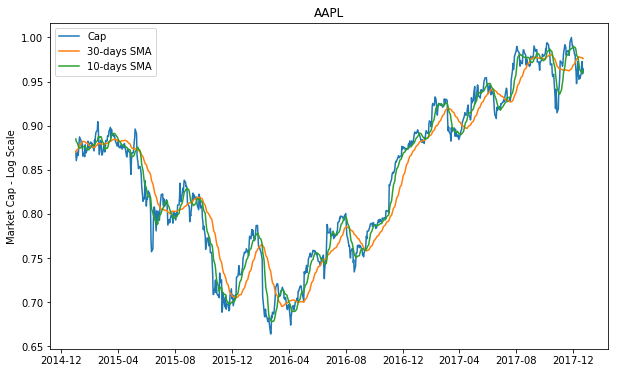

In [25]:

plot_ticker('AAPL', data_dict)

In [26]:
# For the signals, we use the percentage change from one point to another in the moving average, and drop the NaN values (generated because the first value does not have a percentage change)
signal_1 = short_rolling_norm.pct_change(periods=1).shift(-1).dropna().copy()
signal_2 = long_rolling_norm.pct_change(periods=1).shift(-1).dropna().copy()


In [27]:
market = df_cap_norm[df_cap_norm.index.isin(signal_1.index) & df_cap_norm.index.isin(signal_2.index)]
signal_1 = signal_1[signal_1.index.isin(market.index)]
signal_2 = signal_2[signal_2.index.isin(market.index)]

print('Scaled market data:')
display(market.iloc[:5,:10])
print('Scaled signal #1: Short MA')
display(signal_1.iloc[:5,:10])
print('Scaled signal #2: Long MA')
display(signal_2.iloc[:5,:10])


Scaled market data:


,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS
date,,,,,,,,,,
2010-02-12,0.131006,0.179518,0.169158,0.190667,0.609049,0.243287,0.162562,0.214124,0.475642,0.744096
2010-02-15,0.128744,0.163969,0.174093,0.195777,0.607544,0.240514,0.171076,0.218299,0.481652,0.743183
2010-02-16,0.129751,0.166713,0.183400,0.199921,0.614873,0.254873,0.174537,0.230911,0.486538,0.733158
2010-02-17,0.126393,0.164243,0.189403,0.208229,0.617649,0.262723,0.179054,0.228696,0.484582,0.736117
2010-02-18,0.123025,0.160666,0.192634,0.205313,0.615568,0.242733,0.176692,0.230734,0.488922,0.739591


Scaled signal #1: Short MA


,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS
date,,,,,,,,,,
2010-02-12,0.015937,0.000599,0.014446,0.038473,0.005668,-0.013326,0.013695,0.009739,-0.007922,0.000289
2010-02-15,0.008590,0.016482,0.023343,0.041404,0.006557,0.003450,0.004697,0.015933,-0.005031,-0.001360
2010-02-16,0.022634,0.030609,0.039398,0.064134,0.006429,0.022694,0.023142,0.022760,0.001923,0.005092
2010-02-17,0.011339,0.020911,0.045313,0.055304,0.002831,0.014868,0.022985,0.024001,0.005816,0.002319
2010-02-18,0.006728,0.022217,0.040011,0.050193,0.002569,0.015938,0.020636,0.022658,0.004558,0.005131


Scaled signal #2: Long MA


,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS
date,,,,,,,,,,
2010-02-12,-0.007328,-0.008750,0.017649,-0.002554,-0.001407,-0.012811,-0.004221,-0.001062,0.002693,-0.004289
2010-02-15,-0.007363,-0.007881,0.015430,-0.003481,-0.000794,-0.012408,-0.003161,-0.002192,0.002709,-0.005535
2010-02-16,-0.006052,-0.011618,0.012844,-0.002393,-0.000335,-0.011650,-0.001470,-0.003766,0.002879,-0.004950
2010-02-17,-0.006703,-0.014811,0.008518,-0.003511,-0.000661,-0.013581,-0.002014,-0.003513,0.000126,-0.005701
2010-02-18,-0.010063,-0.020242,0.007315,-0.008530,-0.001394,-0.016145,-0.003152,-0.004940,-0.002281,-0.004864


In [28]:
# Create a model class and train it

import time
from datetime import timedelta
class IRL_model():
    
    def __init__(self, num_timesteps, num_stocks, learning_rate=1e-3):
        
        self.t = num_timesteps
        self.n = num_stocks
        print('Setting up model with t={} time steps and n={} stocks'.format(self.t,self.n))        
        
        print('Setting up tensorflow...', end=' ')        
        # here we set up the graph
        tf.reset_default_graph()
        self.x  = tf.placeholder(shape = (None, self.n), dtype = tf.float32, name = 'x' )  # market
        self.z1 = tf.placeholder(shape = (None, self.n), dtype = tf.float32, name = 'z1' ) # signal 1
        self.z2 = tf.placeholder(shape = (None, self.n), dtype = tf.float32, name = 'z2' ) # sigmal 2
        

        # weights
        self.w1_init = tf.random_normal([self.n], mean=0.5, stddev=0.1)
        self.w2_init = 1 - self.w1_init
        self.w1      = tf.get_variable('w1', initializer = self.w1_init)
        self.w2      = tf.get_variable('w2', initializer = self.w2_init)
        self.W1      = self.w1*tf.ones(self.n)
        self.W2      = self.w2*tf.ones(self.n)
        self.k       = 2
        
        # parameters
        self.sigma = tf.get_variable('sigma', initializer = tf.random_uniform([self.n], minval=0.0, maxval=0.1))
        self.kappa = tf.get_variable('kappa', initializer = tf.random_uniform([self.n], minval=0.0, maxval=1.0))
     
        
        self.mu    = tf.zeros([self.n])
        self.Sigma = self.sigma * tf.ones([self.n])
        self.Kappa = self.kappa * tf.ones([self.n])
       
        
        self.signals1 = tf.multiply(self.W1, self.z1)
        self.signals2 = tf.multiply(self.W2, self.z2)
        self.scale    = tf.slice(self.x, [0,0], [1,-1])
        self.signals  = tf.multiply(self.scale, tf.cumprod(1 + tf.add(self.signals1, self.signals2)))
        
        # now we add some non-negative constraints on the weights
        self.w1_abs      = self.w1.assign(tf.maximum(0., self.w1))
        self.w2_abs      = self.w2.assign(tf.maximum(0., self.w2))
       
        self.constraints = tf.group(self.w1_abs, self.w2_abs)

        # expression
               
        self.r = tf.divide( tf.subtract( tf.manip.roll( self.x, shift = -1, axis = 0), self.x),self.x)
        self.v = tf.subtract( self.r, tf.multiply( self.Kappa, tf.subtract( self.signals, self.x) ) )
        self.V = tf.slice(self.v, [0,0], [tf.shape(self.v)[0]-1, -1])
        
       
        
        # negative log-likelyhood
        self.distribution = tf.contrib.distributions.MultivariateNormalDiag(loc=self.mu, scale_diag=self.Sigma)
        self.log_prob     = self.distribution.log_prob(self.V)
        self.reg_term     = tf.reduce_sum(tf.square(self.w1 + self.w2 - 1))
        self.neg_log_likelihood = -tf.reduce_sum(self.log_prob) + 0.01 * self.reg_term
        
        # configure the optimizer
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
        self.train_op  = self.optimizer.minimize(self.neg_log_likelihood)
        
        print('Model Ready!')
        return
    
    def fit(self, market, signal_1, signal_2, epochs=1000, tol=1e-3):
        start = time.time()
        assert not np.any(np.isnan(market))
        assert not np.any(np.isnan(signal_1))
        assert not np.any(np.isnan(signal_2))
        
        with tf.Session() as sess:
                
            sess.run(tf.global_variables_initializer())
            
            # run the first iteration and calculate initial loss
            res = []
            self.loss = []
            res.append(sess.run(self.neg_log_likelihood, \
                                feed_dict = {self.x: market, self.z1: signal_1, self.z2: signal_2}))
            
            # now iterate loss minimization in a loop
            e=1
            while True:
                # solve the optimiser
                sess.run(self.train_op, feed_dict={self.x: market, self.z1: signal_1, self.z2: signal_2})
                # abide by contraints
                sess.run(self.constraints) 

                # update loss
                res.append(sess.run(self.neg_log_likelihood, \
                                    feed_dict={self.x: market, self.z1: signal_1, self.z2: signal_2}))
                loss_ = np.abs(res[-1] - res[-2])
                self.loss.append(loss_)

                if (e % 200 == 0) or (e == 1):
                    print('Epoch {:5}: Loss: {}'.format(e, loss_))

                if loss_ < tol:
                    print('Converged after {} epochs. Loss: {}'.format(e, loss_))
                    break

                if e >= epochs:
                    print('Specified maximum epochs ({}) reached without convergence. Loss: {}'.format(epochs, loss_))
                    break

                e += 1
                
            end = time.time()            
            
            # Save the coefficients
            self.coefficients = pd.DataFrame([], index = market.columns, \
                                             columns = ['kappa', 'sigma', 'w1', 'w2'] )  # 'theta', 'g',
            self.coefficients['kappa']   = sess.run(self.kappa)
            self.coefficients['sigma']   = sess.run(self.sigma)
            self.coefficients['w1']      = sess.run(self.W1)
            self.coefficients['w2']      = sess.run(self.W2)
            
            est_ = sess.run(self.signals, feed_dict={self.x: market, self.z1: signal_1, self.z2: signal_2})
            self.estimation = pd.DataFrame(est_, index=market.index, columns=market.columns)
            
        print('Training Complete. Elapsed time:', timedelta(seconds=end-start))

In [29]:
part1_model = IRL_model(market.shape[0], market.shape[1], learning_rate=1.5e-3)
part1_model.fit(market, signal_1, signal_2, epochs=1000, tol=1)


Setting up model with t=2050 time steps and n=30 stocks
Setting up tensorflow... Model Ready!
Epoch     1: Loss: 29029.51953125
Epoch   200: Loss: 8.46875
Epoch   400: Loss: 2.9375
Epoch   600: Loss: 1.0546875
Converged after 622 epochs. Loss: 0.9921875
Training Complete. Elapsed time: 0:00:54.458031


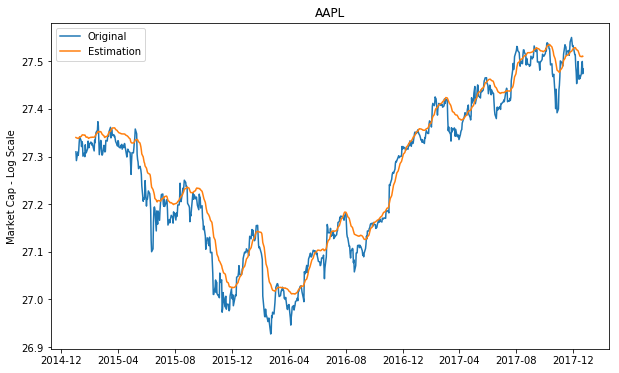

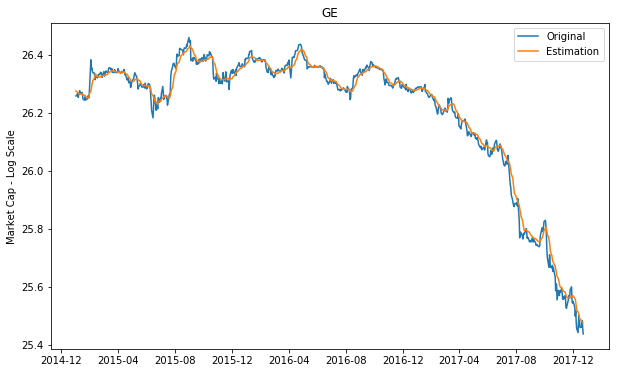

In [30]:
estimation = df_cap_scaler.inverse_transform(part1_model.estimation)
df_est = pd.DataFrame(estimation, columns=part1_model.estimation.columns, index=part1_model.estimation.index)

data_dict = {'Original': df_cap_log, 'Estimation': df_est}

plot_ticker('AAPL', data_dict)

ticker = np.random.choice(df_cap.columns.values)
plot_ticker(ticker, data_dict)


In [31]:
part1_model.coefficients.head()

,kappa,sigma,w1,w2
AAPL,0.051243,0.017296,0.437385,0.534170
AXP,0.236954,0.044007,0.484144,0.409106
BA,0.748920,0.034166,0.508010,0.377404
CAT,0.307971,0.032115,0.349920,0.539916
CSCO,0.164538,0.043771,0.949313,0.000000


## Part 2: Propose other signals and investigate the dynamics for market caps obtained with alternative signals. Present your conclusions and observations. (Max 10 point)

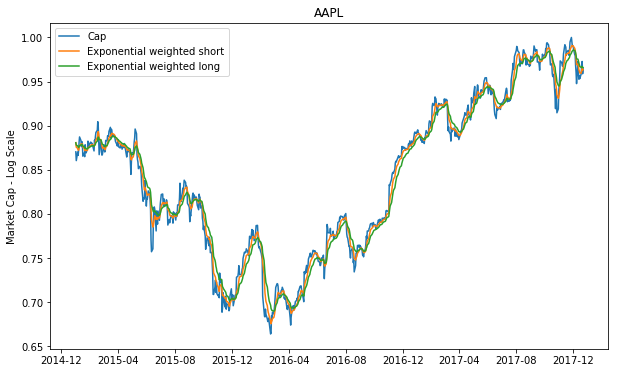

In [32]:
# Put the rest of your code and analysis for Part 2 here.
# Trying Exponentially Weighted long and short MA

exponential_weighted_short = df_cap_norm.ewm(span=7, adjust=False).mean()
exponential_weighted_long  = df_cap_norm.ewm(span=15, adjust=False).mean()
data_dict = {'Cap': df_cap_norm, 
             'Exponential weighted short': exponential_weighted_short, 
             'Exponential weighted long': exponential_weighted_long}
plot_ticker('AAPL', data_dict)


In [35]:
# For the signals, we use the percentage change from one point to another in the moving average, and drop the NaN values (generated because the first value does not have a percentage change)
signal_2_1 = exponential_weighted_short.pct_change(periods=1).shift(-1).dropna().copy()
signal_2_2 = exponential_weighted_long.pct_change(periods=1).shift(-1).dropna().copy()

market_2 = df_cap_norm[df_cap_norm.index.isin(signal_2_1.index) & df_cap_norm.index.isin(signal_2_2.index)]
signal_2_1 = signal_2_1[signal_2_1.index.isin(market_2.index)]
signal_2_2 = signal_2_2[signal_2_2.index.isin(market_2.index)]

print('Scaled market data:')
display(market_2.iloc[:5,:10])
print('Scaled Exp Signal #1: Short ExpMA')
display(signal_2_1.iloc[:5,:10])
print('Scaled Exp Signal #2: Long ExpMA')
display(signal_2_2.iloc[:5,:10])


Scaled market data:


,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS
date,,,,,,,,,,
2010-01-04,0.157602,0.211608,0.100000,0.209723,0.632963,0.350976,0.191274,0.225279,0.442688,0.841472
2010-01-05,0.158535,0.209245,0.117477,0.218882,0.629196,0.360491,0.189602,0.245302,0.447230,0.859443
2010-01-06,0.149876,0.226451,0.133684,0.221219,0.623686,0.360660,0.186035,0.253369,0.442688,0.848439
2010-01-07,0.148877,0.239049,0.155205,0.224325,0.627478,0.355572,0.186246,0.253665,0.487080,0.868311
2010-01-08,0.152455,0.238282,0.149948,0.232930,0.631938,0.357949,0.187296,0.255290,0.505818,0.848733


Scaled Exp Signal #1: Short ExpMA


,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS
date,,,,,,,,,,
2010-01-04,0.001480,-0.002791,0.043693,0.010918,-0.001488,0.006777,-0.002185,0.022221,0.002565,0.005339
2010-01-05,-0.012606,0.018285,0.070218,0.010856,-0.003297,0.005169,-0.006315,0.025061,-0.000640,0.000731
2010-01-06,-0.011178,0.028125,0.097377,0.011678,-0.000976,0.000275,-0.004489,0.018650,0.024541,0.006416
2010-01-07,-0.002674,0.019649,0.055830,0.018579,0.001039,0.001879,-0.001991,0.015421,0.028274,-0.000963
2010-01-08,-0.009794,0.000748,0.027170,0.066823,-0.000174,0.018058,-0.016102,0.005464,0.025135,-0.005512


Scaled Exp Signal #2: Long ExpMA


,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS
date,,,,,,,,,,
2010-01-04,0.000740,-0.001396,0.021847,0.005459,-0.000744,0.003389,-0.001093,0.011110,0.001282,0.002670
2010-01-05,-0.006215,0.008955,0.038532,0.006136,-0.001740,0.003015,-0.003291,0.014042,-0.000160,0.000699
2010-01-06,-0.006269,0.015152,0.057814,0.007166,-0.000775,0.000830,-0.002751,0.012277,0.012380,0.003554
2010-01-07,-0.002649,0.012617,0.041969,0.011260,0.000205,0.001566,-0.001722,0.011481,0.015921,0.000210
2010-01-08,-0.006174,0.003860,0.028335,0.036899,-0.000296,0.009738,-0.008768,0.006872,0.016026,-0.002221


In [36]:
part2_model = IRL_model(market_2.shape[0], market_2.shape[1], learning_rate=1.5e-3)
part2_model.fit(market_2, signal_2_1, signal_2_2, epochs=1000, tol=1)


Setting up model with t=2079 time steps and n=30 stocks
Setting up tensorflow... Model Ready!
Epoch     1: Loss: 361492.21875
Epoch   200: Loss: 22.1171875
Epoch   400: Loss: 7.8828125
Epoch   600: Loss: 3.8359375
Epoch   800: Loss: 1.6171875
Converged after 999 epochs. Loss: 0.984375
Training Complete. Elapsed time: 0:01:25.770499


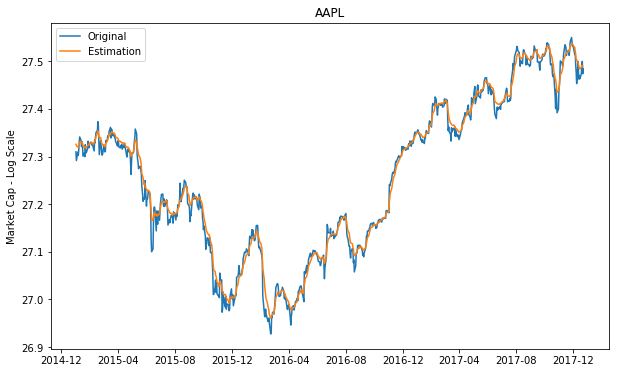

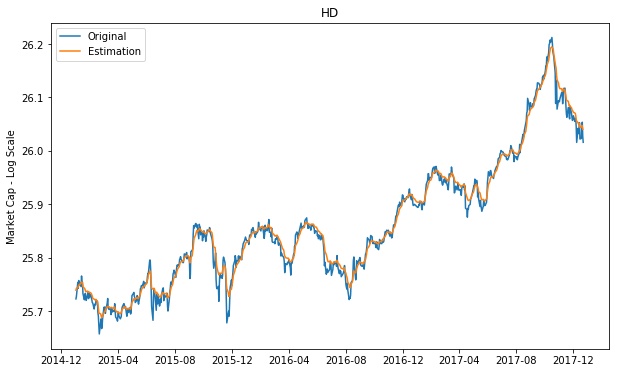

In [37]:
estimation_2 = df_cap_scaler.inverse_transform(part2_model.estimation)
df_est = pd.DataFrame(estimation_2, columns=part2_model.estimation.columns, index=part2_model.estimation.index)

data_dict = {'Original': df_cap_log, 'Estimation': df_est}

plot_ticker('AAPL', data_dict)

ticker = np.random.choice(df_cap.columns.values)
plot_ticker(ticker, data_dict)


In [38]:
part2_model.coefficients.head()

,kappa,sigma,w1,w2
AAPL,0.391411,0.019803,0.727084,0.273489
AXP,1.003471,0.044547,1.000940,0.000000
BA,1.362375,0.030962,1.001735,0.000000
CAT,0.778036,0.033937,1.002269,0.000000
CSCO,1.019482,0.042020,0.992826,0.000000


In [46]:
print("Part2_model appears to give better estimations using exponential moving averages compared to Part1_model which uses only moving averages.")

print("End of Part 2")




Part2_model appears to give better estimations using exponential moving averages compared to Part1_model which uses only moving averages.
End of Part 2


## Part 3: Can you do it for the S&P500 market portfolio? (Max 10 point)

Try to repeat your analysis for the S&P500 portfolio. 

The data can be obtained from Course 2 "Fundamentals of Machine Learning in Finance" in this Specialization.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from datetime import datetime


In [ ]:
df_cap = pd.read_csv('spx_holdings_and_spx_closeprice.csv',
                     date_parser=lambda dt: pd.to_datetime(dt, format='%Y-%m-%d'),
                     index_col = 0).dropna()
df_cap.head()

## Part 4 (Optional): Show me something else.

Here you can develop any additional analysis of the model that you may find interesting (One possible suggestion is 
presented above, but you should feel free to choose your own topic). Present your case and finding/conclusions.


In [ ]:
# Put the rest of your code and analysis for Part 3 here.